# COSC 424/525 Homework 4
In this homework you will learn about building convolutional neural networks, residual networks, and recurrent neural networks. The main objectives of the homework is to reinforce the theory discussed in class by building such architectures from scratch and apply some of these methods to real world problems.

**General Instructions**
1. All coding should be done in Python 3
2. Always vectorize your code when possible
3. Create a Code and Markdown cells after each subtask to test and document your progress.
4. Comment your code thoroughly
5. Use a separate write-up Word file to document the experiments specified below.
5. Export your notebook and Word file in PDF format. Make sure that your PDF contains all notebook output.
6. Submit the PDF files and your Jupyter Notebook.

**Detailed Instructions**
1. CNN Step by Step [Points 40]
2. CNN Application [Points 20]
3. ResNet50 Implementation [Points 20]
4. RNN Application [Points 20]

# 2. Convolutional Neural Networks: Application

Credits: The problems in this notebook were mainly produced by Andrew NG's team and deeplearning.ai

In this notebook you will
- Create an image mood classifer using the PyTorch API
- Learn how to use skorch to simplify model training
- Display skorch captured statistics

In [5]:
import random
import numpy as np
import h5py
import matplotlib.pyplot as plt
from skorch import NeuralNetBinaryClassifier
from skorch.callbacks import EpochScoring
from PIL import Image
import pandas as pd
import scipy as sc
import torch
from torchsummary import summary  # You may need to install this library [https://github.com/sksq96/pytorch-summary]

%matplotlib inline

# Seeds
seed_num = 4
random.seed(seed_num)
np.random.seed(seed_num)
torch.manual_seed(seed_num)

## 2.1 - Load the Data and Split the Data into Train/Test Sets

You'll be using the Happy House dataset for this part of the assignment, which contains images of peoples' faces. Your task will be to build a ConvNet that determines whether the people in the images are smiling or not -- because they only get to enter the house if they're smiling!  

In [6]:
def load_happy_dataset(path_to_train, path_to_test):
    
    #load train set
    with h5py.File(path_to_train, 'r') as train_dataset:
        train_x = np.array(train_dataset['train_set_x'])
        train_y = np.array(train_dataset['train_set_y'][:])
        classes = train_dataset['list_classes']

    with h5py.File(path_to_test) as test_dataset:
        test_x = np.array(test_dataset['test_set_x'][:])
        test_y = np.array(test_dataset['test_set_y'][:])

    # y reshaped
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y, classes

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_happy_dataset("./data/happyhouse/train_happy.h5", "./data/happyhouse/test_happy.h5")

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


You can display the images contained in the dataset. Images are **64x64** pixels in RGB format (3 channels).

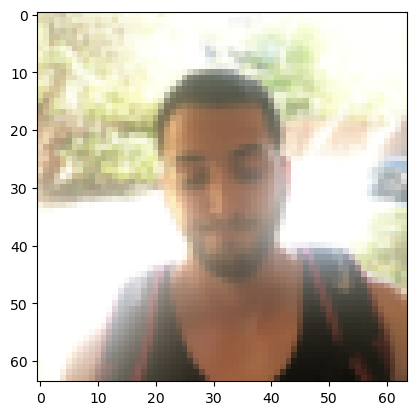

In [7]:
index = 124
plt.imshow(X_train_orig[index]) #display sample training image
plt.show()

### 2.1.1 Create dataset objects

Helper class and processes to produce a valid Torch dataset objects for the validation and training sets.

In [ ]:
###########################
## YOUR CODE STARTS HERE

# Store training and validations sets as tensors
# Convert training and test data to a PyTorch Tensor [m,C,H,W].
# Hint: Original data [m,H,W,C], check np.moveaxis()
# Hint: PyTorch likes Float32 (e.g., dtype=torch.float32)

###############
# X_train_t = 
# X_test_t =
# y_train_t = 
# y_test_t = 
# Convert numpy arrays to PyTorch tensors and adjust dimensions
X_train_t = torch.tensor(np.moveaxis(X_train, -1, 1), dtype=torch.float32)
X_test_t = torch.tensor(np.moveaxis(X_test, -1, 1), dtype=torch.float32)
y_train_t = torch.tensor(Y_train, dtype=torch.float32)
y_test_t = torch.tensor(Y_test, dtype=torch.float32)
## YOUR CODE ENDS HERE
##############################

# Merging training and validation sets in a single dataset to
# show later that skorch can take care of data splitting for us
X_t = torch.cat((X_train_t, X_test_t))
y_t = torch.cat((y_train_t, y_test_t))

: 

## 2.2 - Layers in PyTorch 

In the previous assignment, you created layers manually in numpy. In PyTorch, you don't have to write code directly to create layers. Rather, PyTorch has pre-defined layers you can use. 

When you create a layer in PyTorch, you are creating a function that takes some input and transforms it into an output you can reuse later. Nice and easy! 

### 2.2.1 - Create the Sequential Model

The PyTorch Sequential API can be used to build simple models with layer operations that proceed in a sequential order. 

Actually, you can think of a Sequential model as behaving like a list of layers. Like Python lists, Sequential layers are ordered, and the order in which they are specified matters.  If your model is non-linear or contains layers with multiple inputs or outputs, a Sequential model wouldn't be the right choice!


Implement the `happyModel` function below to build the following model: `CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE -> SIGMOID`.

Also, plug in the following parameters for all the steps:

 - [Conv2D](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d): Use 32 7x7 filters, stride 1
 - [BatchNormalization](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d): for axis 3
 - [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU)
 - [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d): Using default parameters
 - [Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) the previous output.
 - Fully-connected ([Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)) layer: Apply a fully connected layer with 1 neuron. 
 - [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html#torch.nn.Sigmoid)


In [ ]:
# GRADED FUNCTION: happyModel

class HappyModel(torch.nn.Module):
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity and grading purposes, you'll hard-code all the values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    None

    Returns:
    model -- Pytorch model (object containing the information for the entire training process) 
    """

    def __init__(self):
        super(HappyModel, self).__init__()

        self.model = torch.nn.Sequential(
                ###############################
                # YOUR CODE STARTS HERE
                # Conv2D with 32 7x7 filters, padding 'same' and stride of 1
                torch.nn.Conv2d(3, 32, kernel_size=7, stride=1, padding='same'),
                # BatchNormalization for each previous layer output channel
                torch.nn.BatchNorm2d(32),
                # ReLU
                torch.nn.ReLU(),
                # Max Pooling 2D with kernel size of 2, and padding and stride to default values
                torch.nn.MaxPool2d(kernel_size=2),
                # Flatten layer
                torch.nn.Flatten(),
                # Dense layer with 1 unit for output
                torch.nn.Linear(32*32*32, 1),
                # Sigmoid activation output
                torch.nn.Sigmoid()
                # YOUR CODE ENDS HERE
                ###############################
        )

    def forward(self, x):
        out = self.model(x)
        return out

In [ ]:
summary(HappyModel(), input_size=(3,64,64))
    
output = [  ['Conv2D', (-1, 32, 64, 64), 4736],
            ['BatchNormalization', (-1, 32, 64, 64), 128],
            ['ReLU', (-1, 32, 64, 64), 0],
            ['MaxPooling2D', (-1, 32, 32, 32), 0],
            ['Flatten', (-1, 32768), 0],
            ['Dense', (-1, 1), 32769],
            ['Sigmoid', (-1, 1), 0]
        ]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]           4,736
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
         MaxPool2d-4           [-1, 32, 32, 32]               0
           Flatten-5                [-1, 32768]               0
            Linear-6                    [-1, 1]          32,769
           Sigmoid-7                    [-1, 1]               0
Total params: 37,569
Trainable params: 37,569
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 3.50
Params size (MB): 0.14
Estimated Total Size (MB): 3.69
----------------------------------------------------------------


#### Expected Output:

```
['Conv2D',              (-1, 32, 64, 64),   4736],
['BatchNormalization',  (-1, 32, 64, 64),   128],
['ReLU',                (-1, 32, 64, 64),   0],
['MaxPooling2D',        (-1, 32, 32, 32),   0],
['Flatten',             (-1, 32768),        0],
['Dense',               (-1, 1),            32769],
['Sigmoid',             (-1, 1),            0]
```

## 2.2.2 - Train and Evaluate the Model

After creating the model, you will now learn how to use the Scikit-learn and Skorch to quickly train your model.

- Step 1: Define Skorch object to wrap Torch model with parameters 
    - Optimizier: Adam
    - Loss: BCEloss
    - Learning rate: 0.0001
    - max_epochs: 10,
    - batch_size: 16
- Step 2: Initialize model parameters using helper function
    - Hint: check skorch attributes `initialize` and `module_.apply`
- Step 3: Train model

In [ ]:
# Helper function to initialize weights after model creation
def init_weights(module):
    if isinstance(module, torch.nn.Conv2d):
        torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        if module.bias is not None:
            torch.nn.init.constant_(module.bias, 0.3)
    elif isinstance(module, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(module.weight)
        if module.bias is not None:
            torch.nn.init.constant_(module.bias, 0.3)


############################
# YOUR CODE STARTS HERE

# Step 1: Create Skorch wrapper
accuracy = EpochScoring('accuracy', lower_is_better=False)
skorch_model = NeuralNetBinaryClassifier(
    None,
    criterion=None,
    optimizer=None,
    lr=0,
    max_epochs=0,
    batch_size=0,
    callbacks=[accuracy],
)

# Step 2: Initialize weights
skorch_model.initialize()
skorch_model.module_.apply(init_weights)

# Step 3: Train model
skorch_model.fit(X_train_t, y_train_t)
# YOUR CODE ENDS HERE
##############################

## 2.3 - History Object 

The history object is an output of the `.fit()` operation, and provides a record of all the loss and metric values in memory. It's stored as a dictionary that you can retrieve at `skorch_model.history`: 

In [ ]:
skorch_model.history

Now visualize the loss over time using `history.history`: 

In [ ]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(skorch_model.history)
df_loss= df_loss_acc[['train_loss','valid_loss']]
df_loss.rename(columns={'train_loss':'train','valid_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','valid_acc']]
df_acc.rename(columns={'accuracy':'train','valid_acc':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

: 

**Congratulations**! You've finished the assignment. Nicely done! 
